# Assignment I: Part II

Import needed libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
import pandas as pd
import matplotlib.pyplot as plt
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

### Import data

In [2]:
# Load Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize pixel values to [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Subset the dataset
train_size = 10000  # 10,000 for training
val_size = 2000     # 2,000 for validation
test_size = 2000    # 2,000 for testing

# Shuffle the training data (recommended)
shuffle_indices = tf.random.shuffle(tf.range(len(x_train)))
x_train = tf.gather(x_train, shuffle_indices)
y_train = tf.gather(y_train, shuffle_indices)

# Create subsets
x_train_small, y_train_small = x_train[:train_size], y_train[:train_size]
x_val_small, y_val_small = x_train[train_size:train_size + val_size], y_train[train_size:train_size + val_size]
x_test_small, y_test_small = x_test[:test_size], y_test[:test_size]

# Print dataset shapes
print(f"Training set: {x_train_small.shape}, Labels: {y_train_small.shape}")
print(f"Validation set: {x_val_small.shape}, Labels: {y_val_small.shape}")
print(f"Test set: {x_test_small.shape}, Labels: {y_test_small.shape}")


Training set: (10000, 28, 28), Labels: (10000,)
Validation set: (2000, 28, 28), Labels: (2000,)
Test set: (2000, 28, 28), Labels: (2000,)


In [3]:
len(x_train_small)

10000

## Create the model

In [4]:
def add_hidden_layers(num_layers, num_neurons, model):

    # Add convolutional layers (using smaller image size 28x28)
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2,2)))

    if num_layers > 1:
        model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
        model.add(MaxPooling2D((2,2)))

    if num_layers > 2:
        model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
        model.add(MaxPooling2D((2,2)))

    # Flatten for Dense layers
    model.add(Flatten())

    # Add Fully Connected layers
    for i in range(len(num_neurons)):
        model.add(Dense(num_neurons[i], activation="relu"))
        model.add(Dropout(0.3))  # Dropout to prevent overfitting

    return model


In [5]:
def create_model(num_layers, num_neurons):
    """Creates a CNN model for Fashion-MNIST given the number of layers and neurons."""

    # Create the model
    model = Sequential()

    # Add hidden layers (CNN + Dense layers)
    model = add_hidden_layers(num_layers, num_neurons, model)

    # Output layer for Fashion-MNIST (10 classes)
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [6]:
def create_and_eval_model(num_layers, num_neurons, iteration, start_time, report_df):
        with tf.device('/GPU:0'):
                model = create_model(num_layers, num_neurons)  # Example

        # model = create_model(num_layers, num_neurons)
        # start the timer
        tic = time.time()
        # Train and evaluate the model
        model.fit(x_train_small, y_train_small, epochs=10, batch_size =32, validation_data=(x_val_small, y_val_small), verbose=0)
        toc = time.time()
        time_taken = toc - tic
        _, accuracy = model.evaluate(x_test_small, y_test_small, verbose=0)
        time_to_reach_model = time.time() - start_time
        print(f"Iteration {iteration}: Model with {num_layers} layers and {num_neurons} neurons achieved accuracy {accuracy*100:.4f}")

        # add experiment data to the dataframe
        report_df.loc[len(report_df)] = { "iteration_num":iteration,
                                          "layers_num":num_layers, "neurons_num": num_neurons,
                                          "val_accuracy":accuracy,"training_time":time_taken,
                                          "time_to_reach_model":time_to_reach_model}

        return accuracy

## Developing a search criteria

### Approach I: Random Search

The random search works as following:
1. Initially, we take the maximum and minimum number of values for layers and neurons
2. Create ranges of these values, then
3. Randomly choose from those range pools values for both layers and neurons.
4. Repeat step 4, until 10 iterations are done.

In [ ]:
# Define hyperparameter grid
random_report_df = pd.DataFrame(columns=["iteration_num", "layers_num", "neurons_num", "val_accuracy","training_time", "time_to_reach_model"])

In [ ]:
def random_search(start_time, max_initial_layers , num_iterations=10,  max_neurons = 1024 ):
    # Define hyperparameters
    layers_range = list(range(1, max_initial_layers + 1))  # 1 to 10 layers
    neurons_range = list(range(1, max_neurons + 1))   # Neurons per layer

    # take a sample of 10 layers randomly
    num_layers = np.random.choice(layers_range, size=10, replace=True)

    # choose the neurons per each layer randomly
    num_layers_neurons = []
    for layers in num_layers:
        num_layers_neurons.append( list(np.random.choice(neurons_range, size=layers, replace=True) ))

    # the best accuracy to show info
    rand_best_accuracy = 0
    best_random_model_num = None
    # run the algorithm
    for iteration in range(1, num_iterations + 1):
        # pick the model layers along with its neurons
        num_neurons = num_layers_neurons[iteration - 1]
        temp_accuracy = create_and_eval_model(num_layers[iteration - 1] , num_neurons, iteration, start_time, random_report_df)
        if temp_accuracy > rand_best_accuracy:
            rand_best_accuracy = temp_accuracy
            best_random_model_num = iteration - 1

    print(f"Best model achieved accuracy: {rand_best_accuracy*100:.4f} with {num_layers[best_random_model_num]} layers and {num_layers_neurons[best_random_model_num]} neurons")
    return best_random_model_num


In [ ]:
# tic = time.time()
# start_time = tic
# # Example usage with adaptive random search
# random_best_model = random_search(start_time, num_iterations=10, max_initial_layers=10)
# # Time taken
# toc = time.time()
# random_time_taken = toc - tic # the time taken for full search
# print(f"Full search time for Random Search:{random_time_taken} for {random_report_df.shape[0]} models tested.")

In [ ]:
# random_report_df.to_csv("random_FashionMNIST_report.csv", index = False)

### Approach I: Adaptive Random Search

In this approach, the following peseudo code describes the algorithm:
1. Initialize the number of layers and neurons randomly in the defined search space.
2. Store the accuracy.
3. increase the search space in the direction that gives the best space (increase/decreasing).


In [ ]:
# Starting from the same point as the random search
ras_report_df = random_report_df.head(1).copy()
ras_report_df

In [7]:
# Adaptive Random Search function
def adaptive_random_search_v2(start_time, num_iterations, max_initial_layers, max_initial_neurons, min_layers=1, min_neurons=8 ):
    ras_best_accuracy = 0
    best_model_no = None
    best_layers = None
    best_neurons = None
    layer_visited = []
    repeated_layer = 0
    layers_improvement = False

    # Temporary variables to store number of neurons, layers
    additional_neurons = 8  # the number of neurons to add when expanding the width of the NN, increases by multiple of 2
    # Variable of maximum are stretched when applied to adding new neurons
    max_neurons = max_initial_neurons

    # initially starting from the same point as Random Search
    num_layers = ras_report_df.at[0,"layers_num"]
    num_neurons = ras_report_df.at[0,"neurons_num"]
    ras_temp_accuracy = ras_report_df.at[0,"val_accuracy"]
    ras_best_accuracy = ras_temp_accuracy
    layer_visited.append(num_layers)
    prev_layer = num_layers
    print(f"Iteration {1}: Model with {num_layers} layers and {num_neurons} neurons achieved accuracy {ras_temp_accuracy*100:.4f}")

    # Starting search space
    for iteration in range(2, num_iterations + 1):
        '''First time, initialize the layers and the neurons randomly'''

        # make zero all the values except the current num-layer increase by one
        if prev_layer == num_layers:
          repeated_layer = repeated_layer + 1
        else:
            repeated_layer = 1
            prev_layer = num_layers

        '''If the model performs well, add a new layer'''
        if (ras_temp_accuracy >= ras_best_accuracy) or layers_improvement:
            ras_best_accuracy = ras_temp_accuracy
            best_model_no = iteration
            best_layers = num_layers
            best_neurons = num_neurons
            layers_improvement = False
            # Expand the search in the direction of adding more layers if the accuracy is getting better.
            num_layers = max(layer_visited) + 1 # increase the number of layers by one
            # Add neurons for this new added layer and keep the previous as is.
            layer_visited.append(num_layers)
            # if this key not in repeated values add it

            max_neurons = min( (max_neurons + additional_neurons) , 1024)
            for _ in range( num_layers - best_layers ):
              num_neurons = np.append(num_neurons, np.random.randint(min_neurons, max_neurons + 1))

        else:
            ''' Now, we expand the width of the network by adding more neurons gradually.
                when the addition of layer is not working, we add neurons to last best layer
                then work on it. '''
            # Check if this layer has its neurons doubled twice move after each other to next layer after it

            temp = []
            for i in range(best_layers):
                temp.append( min( (num_neurons[i] + additional_neurons),  1024) )
            # Shrink the search space if this architecture didn't perform well (explore less)
            num_neurons = temp
            num_layers = best_layers
            additional_neurons *= 2  # increase by multiple of 2

            if repeated_layer == 2:
              layers_improvement = True

        # Run the model and get its accuracy
        ras_temp_accuracy = create_and_eval_model(num_layers, num_neurons, iteration, start_time, ras_report_df)

    print(f"Best model achieved accuracy: {ras_best_accuracy*100:.4f} with {best_layers} layers and {best_neurons} neurons")
    return best_model_no


In [ ]:
# tic = time.time()
# start_time = tic
# # Example usage with adaptive random search
# best_model_no = adaptive_random_search_v2(start_time, num_iterations=10, max_initial_layers=10, max_initial_neurons=256)

# # Time taken
# toc = time.time()
# time_taken = toc - tic # the time taken for full search
# print(f"Full search time for RAS:{time_taken} for {ras_report_df.shape[0]} models tested.")

In [ ]:
# ras_report_df_v2.to_csv("RASv2_FashionMNIST_report.csv", index=False)

### Approach III: Grid Search

In Grid Search, we will do the following:
1. Define a model, whose functions are defined earlier.
2. Specify the possible values of layers and neurons.
    - Hidden Layers Range [1, 2, 3, ....., 10], which is limited by number of iterations in this code for all the approaches.
    - Number of Neurons []
3. Obtain a set of values from this grid as it is not possible to run over the entire search space.
3. Run the Grid Search Storing on the random selected values.


In [ ]:
# Define hyperparameter grid
grid_report_df = pd.DataFrame(columns=["iteration_num", "layers_num", "neurons_num", "val_accuracy","training_time", "time_to_reach_model"])

In [ ]:
def grid_random_search(start_time, num_iterations=10, max_initial_layers=10):
    # Define hyperparameters
    num_layers_range = list(range(1, max_initial_layers + 1))  # 1 to 10 layers
    num_neurons_range = [8, 16, 32, 64, 128, 256, 512, 1024]  # Neurons per layer

    # take a sample of 10 layers randomly
    num_layers = np.random.choice(num_layers_range, size=10, replace=True)

    # choose the neurons per each layer randomly
    num_layers_neurons = []
    for layers in num_layers:
        num_layers_neurons.append( list(np.random.choice(num_neurons_range, size=layers, replace=True) ))

    # the best accuracy to show info
    grid_best_accuracy = 0
    best_model_num = None
    # run the algorithm
    for iteration in range(1, num_iterations + 1):
        # pick the model layers along with its neurons
        num_neurons = num_layers_neurons[iteration - 1]
        accuracy = create_and_eval_model(num_layers[iteration - 1] , num_neurons, iteration, start_time, grid_report_df)
        if accuracy > grid_best_accuracy:
            grid_best_accuracy = accuracy
            best_model_num = iteration - 1

    print(f"Best model achieved accuracy: {grid_best_accuracy*100:.4f} with {num_layers[best_model_num]} layers and {num_layers_neurons[best_model_num]} neurons")
    return best_model_num


In [ ]:
# tic = time.time()
# start_time = tic
# # Example usage with adaptive random search
# grid_best_model = grid_random_search(start_time, num_iterations=10, max_initial_layers=10)
# # Time taken
# toc = time.time()
# grid_time_taken = toc - tic # the time taken for full search
# print(f"Full search time for Grid Search:{time_taken} for {grid_report_df.shape[0]} models tested.")

In [ ]:
# grid_report_df.to_csv("grid_FashionMNIST_report.csv", index = False)

# Runing Algos 10 times

In this part, the above algorithm will be ran 10 times in which each time, the algorithm will be started all over again to avoid any coincidence of results.

In [ ]:
# creating an overall dataframe for all the experiments
run_results_df = pd.DataFrame(columns=[ "runNo", 
                                        "iteration_num",
                                        "layers_num", 
                                        "neurons_num", 
                                        "val_accuracy",
                                        "training_time", 
                                        "time_to_reach_model",
                                        "algo"])

In [ ]:
# Organize results and add them to the main
def add_run_results(result_df, algo_name, run_no):
    global run_results_df, up_to_best_df
    # make a temporary copy to manipulate
    temp = result_df.copy()
    temp["algo"] = algo_name
    temp["runNo"] = run_no

    # add to the main results
    run_results_df = pd.concat([run_results_df, temp], ignore_index=True)
    
    # clear the original dataframe to be prepared for next run
    result_df = pd.DataFrame(columns=result_df.columns)

In [ ]:
# Run the algorithms for 10 times
for runNo in range(1, 11):
    # Call for the algorithm Random 
    start_time = time.time()
    random_best_model = random_search(start_time, num_iterations=10, max_initial_layers=10)
    # initialize the adaptive random search to the same start point of the random search
    ras_report_df = random_report_df.head(1).copy()
    # add its data to the results df
    add_run_results(random_report_df, "RAN", runNo)

    # Start the adaptive random search
    
    start_time = time.time()
    adaptive_random_search_v2(start_time, num_iterations=10, max_initial_layers=10, max_initial_neurons=256)
    add_run_results(ras_report_df, "ARSv2", runNo )
    
    # Run the grid search 
    start_time = time.time()
    grid_random_search(start_time, num_iterations=10, max_initial_layers=10)
    add_run_results(grid_report_df, "GS", runNo)

In [ ]:
# Save run_results_df to CSV
run_results_df.to_csv("run_results_fashion_all.csv", index=False)

#### Missed ARS

In [10]:
all_results_df = pd.read_csv("run_results_fashion_all - Copy.csv")
# add this to the run_results_df
run_results_df = pd.concat([run_results_df, all_results_df])

# create Ras dataframe
ras_report_df = pd.DataFrame(columns=run_results_df.columns)

In [11]:
import ast  # To safely convert string representation of a list to an actual list
run_results_df["neurons_num"] = run_results_df["neurons_num"].apply(ast.literal_eval)

print(type(run_results_df["neurons_num"][0]))  # Output: <class 'list'>


<class 'list'>


In [12]:
# Organize results and add them to the main
def add_run_results(result_df, algo_name, run_no):
    global run_results_df, ras_report_df
    # make a temporary copy to manipulate
    result_df["algo"] = algo_name
    result_df["runNo"] = run_no

    # add to the main results
    run_results_df = pd.concat([run_results_df, result_df], ignore_index=True)

    # clear the original dataframe to be prepared for next run
    result_df = pd.DataFrame(columns=result_df.columns)
    ras_report_df = None

In [ ]:
for runNo in range(2, 11):
    global ras_report_df
    # initialize the adaptive random search to the same start point of the random search
    ras_report_df =  run_results_df[(run_results_df['runNo'] == runNo) & (run_results_df['algo'] == 'RAN') & (run_results_df['iteration_num'] == 1)]
    ras_report_df = ras_report_df.reset_index(drop=True)
    ras_report_df
    # Start the adaptive random search
    
    start_time = time.time()
    adaptive_random_search_v2(start_time, num_iterations=10, max_initial_layers=10, max_initial_neurons=256)
    add_run_results(ras_report_df, "ARS", runNo )
    

Iteration 1: Model with 9 layers and [429, 331, 708, 426, 317, 13, 210, 681, 329] neurons achieved accuracy 81.3500
Iteration 2: Model with 10 layers and [429 331 708 426 317  13 210 681 329  43] neurons achieved accuracy 74.3000
Iteration 3: Model with 9 layers and [437, 339, 716, 434, 325, 21, 218, 689, 337] neurons achieved accuracy 82.3500
Iteration 4: Model with 11 layers and [437 339 716 434 325  21 218 689 337 123 213] neurons achieved accuracy 55.8500
Iteration 5: Model with 9 layers and [453, 355, 732, 450, 341, 37, 234, 705, 353] neurons achieved accuracy 63.5000
Iteration 6: Model with 9 layers and [485, 387, 764, 482, 373, 69, 266, 737, 385] neurons achieved accuracy 82.6500
Iteration 7: Model with 12 layers and [485 387 764 482 373  69 266 737 385 185 185 275] neurons achieved accuracy 75.2000
Iteration 8: Model with 9 layers and [549, 451, 828, 546, 437, 133, 330, 801, 449] neurons achieved accuracy 84.0500
Iteration 9: Model with 13 layers and [549 451 828 546 437 133 33

In [ ]:
run_results_df.to_csv("All_FashionMNIST_results.csv", , index=False)

# Results Analysis

In [2]:
# Combing the dataframes
# results_df = pd.concat([rand_df, grid_df, ras_df, rasv2_df])
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [3]:
results_df = pd.read_csv("All_FashionMNIST_results.csv")
results_df.head(2)

,runNo,iteration_num,layers_num,neurons_num,val_accuracy,training_time,time_to_reach_model,algo
0,1,1,2,"[953, 39]",0.8905,136.749750,137.591764,RAN
1,1,2,5,"[826, 897, 709, 54, 893]",0.8705,157.039993,295.771287,RAN


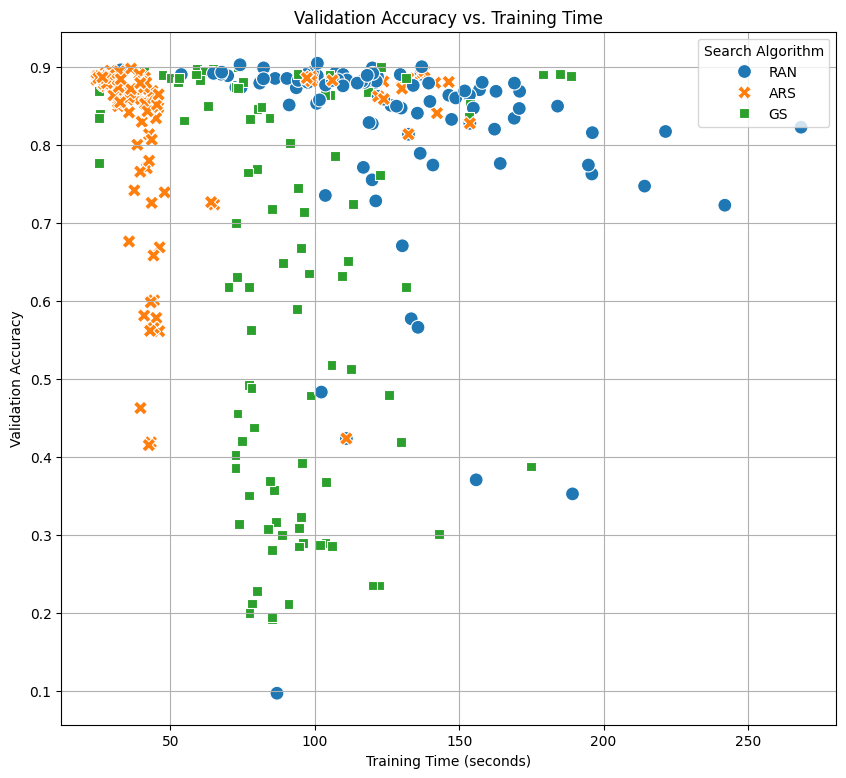

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot for Accuracy vs Training Time, colored by Search Algorithm
plt.figure(figsize=(10, 9))
sns.scatterplot(data=results_df, x='training_time', y='val_accuracy', hue='algo', style='algo', s=100)
plt.title("Validation Accuracy vs. Training Time")
plt.xlabel("Training Time (seconds)")
plt.ylabel("Validation Accuracy")
plt.legend(title="Search Algorithm")
plt.grid(True)
plt.show()


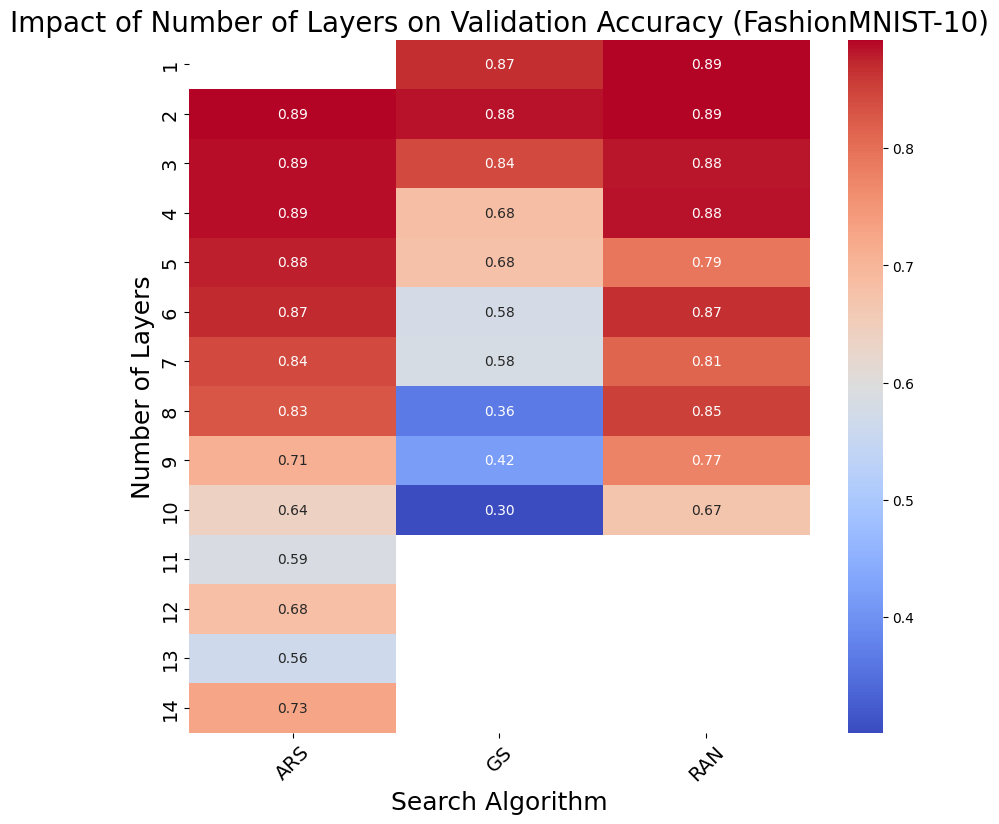

In [5]:
import numpy as np

# Pivoting the dataframe for heatmap
heatmap_data = results_df.pivot_table(values="val_accuracy", index="layers_num", columns="algo", aggfunc=np.mean)

plt.figure(figsize=(10, 9))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Impact of Number of Layers on Validation Accuracy (FashionMNIST-10)", fontsize=20)
plt.xlabel("Search Algorithm", fontsize=18)
plt.ylabel("Number of Layers", fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

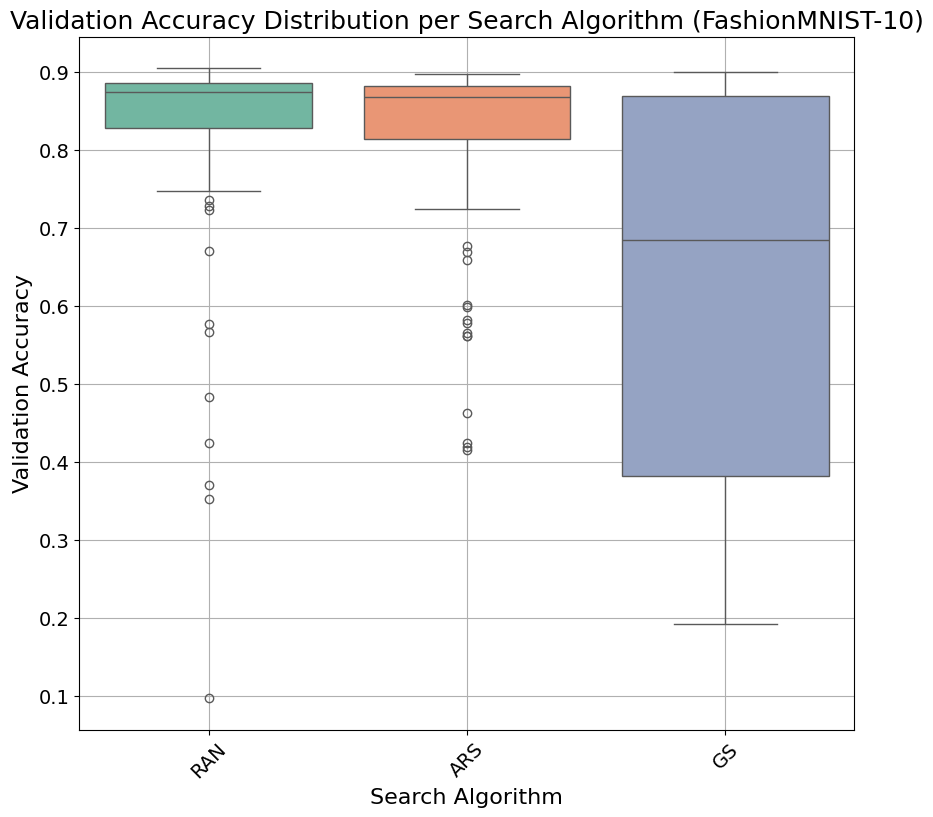

In [6]:
plt.figure(figsize=(10, 9))
sns.boxplot(data=results_df, x="algo", y="val_accuracy", palette="Set2")
plt.title("Validation Accuracy Distribution per Search Algorithm (FashionMNIST-10)", fontsize=18)
plt.xlabel("Search Algorithm", fontsize=16)
plt.ylabel("Validation Accuracy", fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.savefig("images/FashionMNIST.pdf", format='pdf', bbox_inches='tight')
plt.savefig("images/FashionMNIST.png", format='png', bbox_inches='tight')

plt.show()

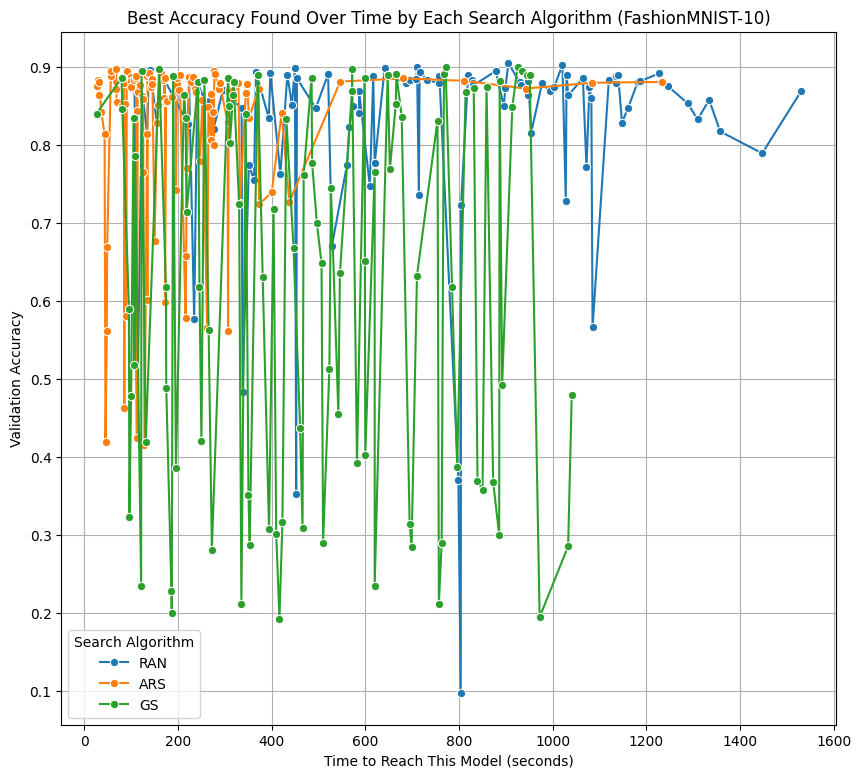

In [7]:
plt.figure(figsize=(10, 9))
sns.lineplot(data=results_df, x="time_to_reach_model", y="val_accuracy", hue="algo", marker="o")
plt.title("Best Accuracy Found Over Time by Each Search Algorithm (FashionMNIST-10)")
plt.xlabel("Time to Reach This Model (seconds)")
plt.ylabel("Validation Accuracy")
plt.legend(title="Search Algorithm")
plt.grid(True)
plt.show()

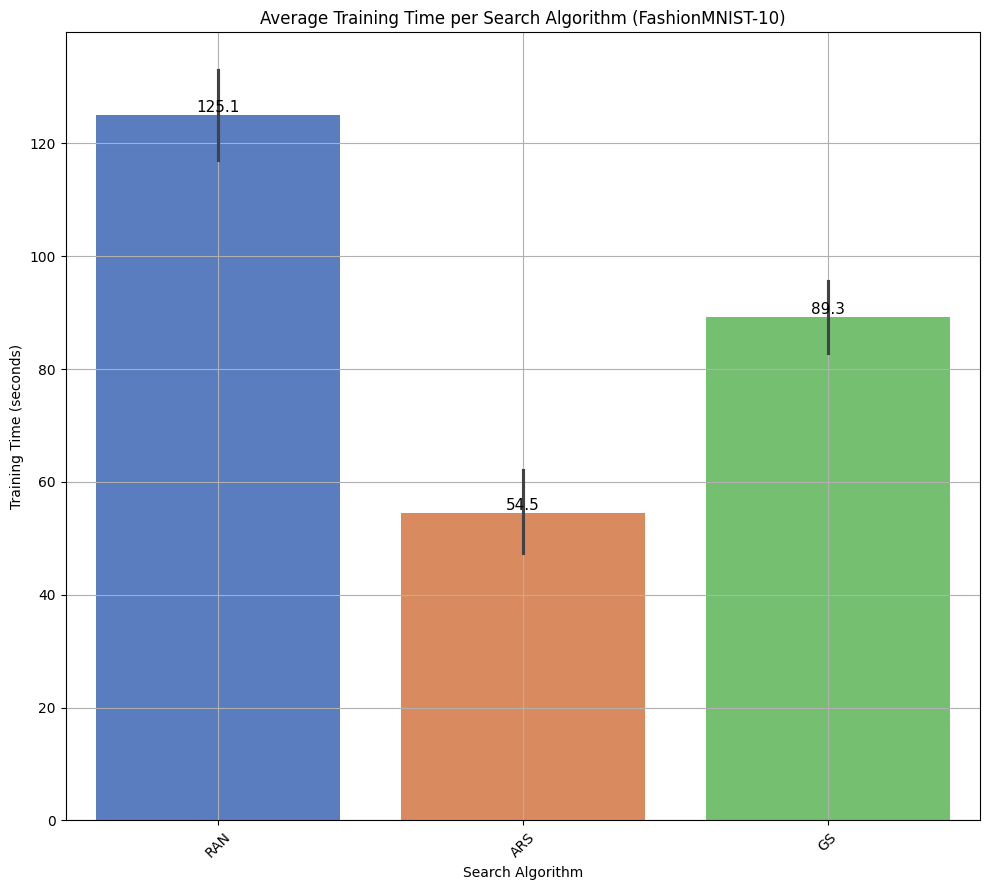

In [8]:
# Plot with values on top of bars
plt.figure(figsize=(10, 9))
ax = sns.barplot(data=results_df, x="algo", y="training_time", palette="muted")

# Annotate each bar with the corresponding value
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=11, color='black')

plt.title("Average Training Time per Search Algorithm (FashionMNIST-10)")
plt.xlabel("Search Algorithm")
plt.ylabel("Training Time (seconds)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

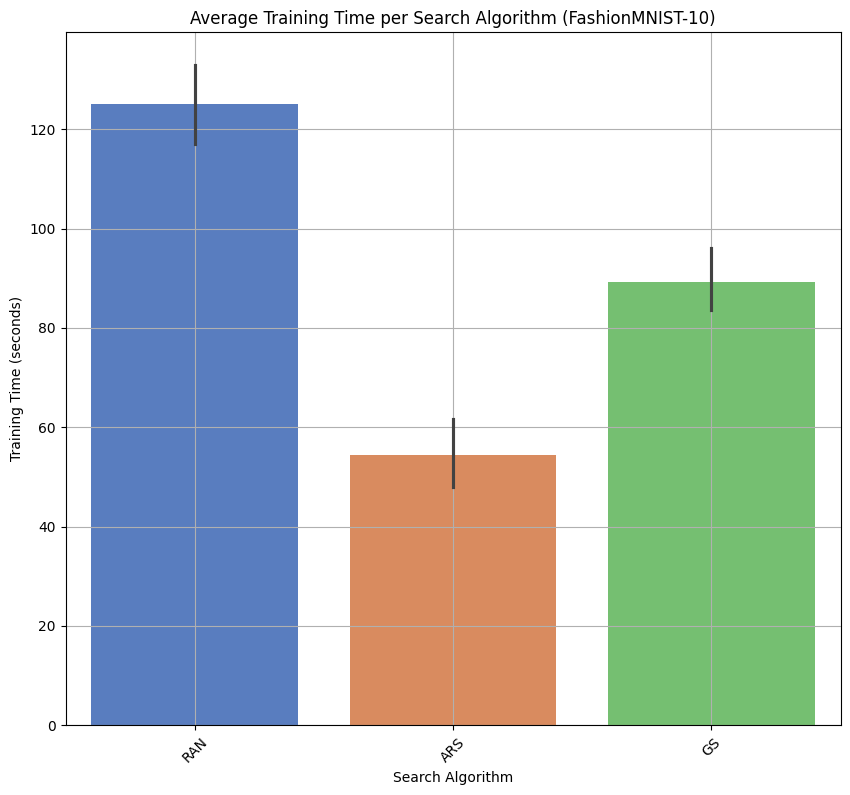

In [9]:
# Average trainging time per search algorithm
plt.figure(figsize=(10, 9))
sns.barplot(data=results_df, x="algo", y="training_time", palette="muted")
plt.title("Average Training Time per Search Algorithm (FashionMNIST-10)")
plt.xlabel("Search Algorithm")
plt.ylabel("Training Time (seconds)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


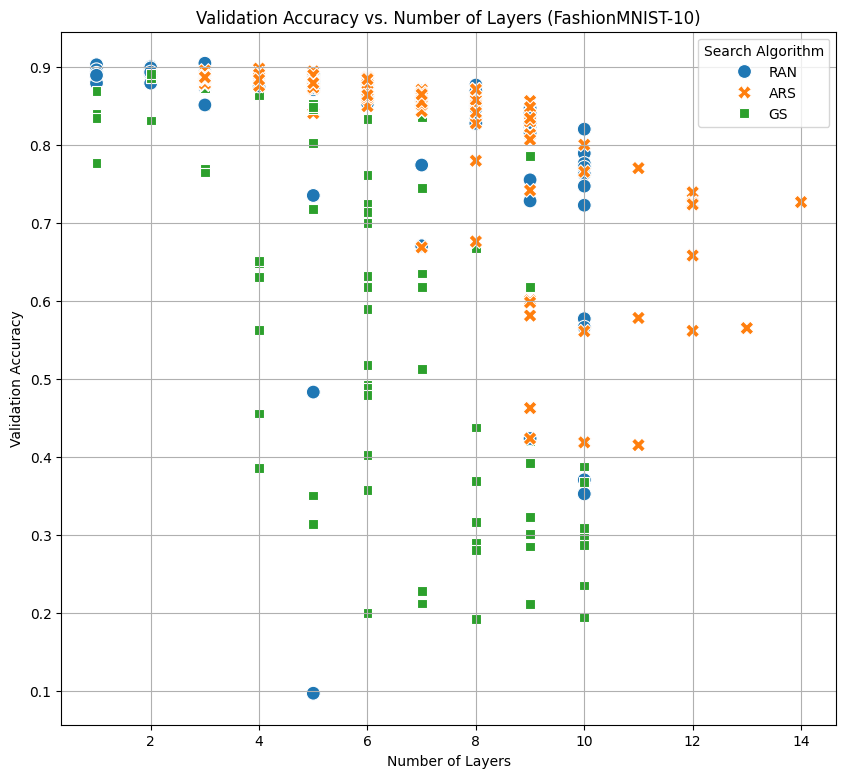

In [10]:
plt.figure(figsize=(10, 9))
sns.scatterplot(data=results_df, x="layers_num", y="val_accuracy", hue="algo", style="algo", s=100)
plt.title("Validation Accuracy vs. Number of Layers (FashionMNIST-10)")
plt.xlabel("Number of Layers")
plt.ylabel("Validation Accuracy")
plt.legend(title="Search Algorithm")
plt.grid(True)
plt.show()


In [11]:
# Group by the NAS algorithm to compare performance
summary_df = results_df.groupby("algo").agg({
    "val_accuracy": ["mean", "max", "min"],
    "training_time": ["mean", "max", "min"],
    "time_to_reach_model": "mean"
}).reset_index()

# Rename columns for clarity
summary_df.columns = ["Algorithm", "Avg Accuracy", "Max Accuracy", "Min Accuracy",
                      "Avg Training Time", "Max Training Time", "Min Training Time",
                      "Avg Time to Reach Model"]

# Display the summary
summary_df


,Algorithm,Avg Accuracy,Max Accuracy,Min Accuracy,Avg Training Time,Max Training Time,Min Training Time,Avg Time to Reach Model
0,ARS,0.815185,0.8975,0.4150,54.469083,153.721875,24.428241,224.339327
1,GS,0.624570,0.8995,0.1925,89.313103,188.847188,25.177496,488.458124
2,RAN,0.824260,0.9045,0.0970,125.108167,268.403903,32.835186,703.842134


In [12]:
print(results_df.dtypes)


runNo                    int64
iteration_num            int64
layers_num               int64
neurons_num             object
val_accuracy           float64
training_time          float64
time_to_reach_model    float64
algo                    object
dtype: object


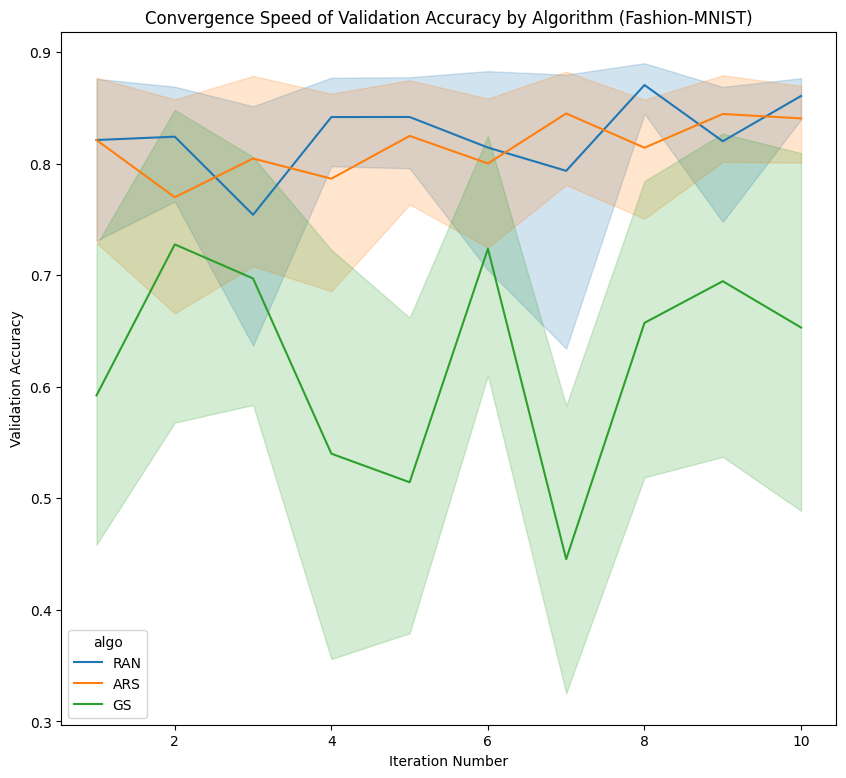

In [13]:
# 1. Convergence Speed
plt.figure(figsize=(10, 9))
sns.lineplot(x='iteration_num', y='val_accuracy', hue='algo', data=results_df)
plt.title('Convergence Speed of Validation Accuracy by Algorithm (Fashion-MNIST)')
plt.xlabel('Iteration Number')
plt.ylabel('Validation Accuracy')
plt.show()

### Up to the best model

In [14]:
# Obtain the models up to the point where the maximum accuracy is reached
up_tobest_model = pd.DataFrame(columns=results_df.columns)

for runNo in range(1, 11):
    for algo in ['ARS', 'RAN', 'GS']:
        temp_df = results_df[(results_df['runNo'] == runNo) & (results_df['algo'] == algo)].reset_index(drop=True)
        
        if not temp_df.empty:
            best_index = temp_df["val_accuracy"].idxmax() + 1
            best_model_df = temp_df.iloc[:best_index]  # Select models up to best one
            up_tobest_model = pd.concat([up_tobest_model, best_model_df], ignore_index=True)

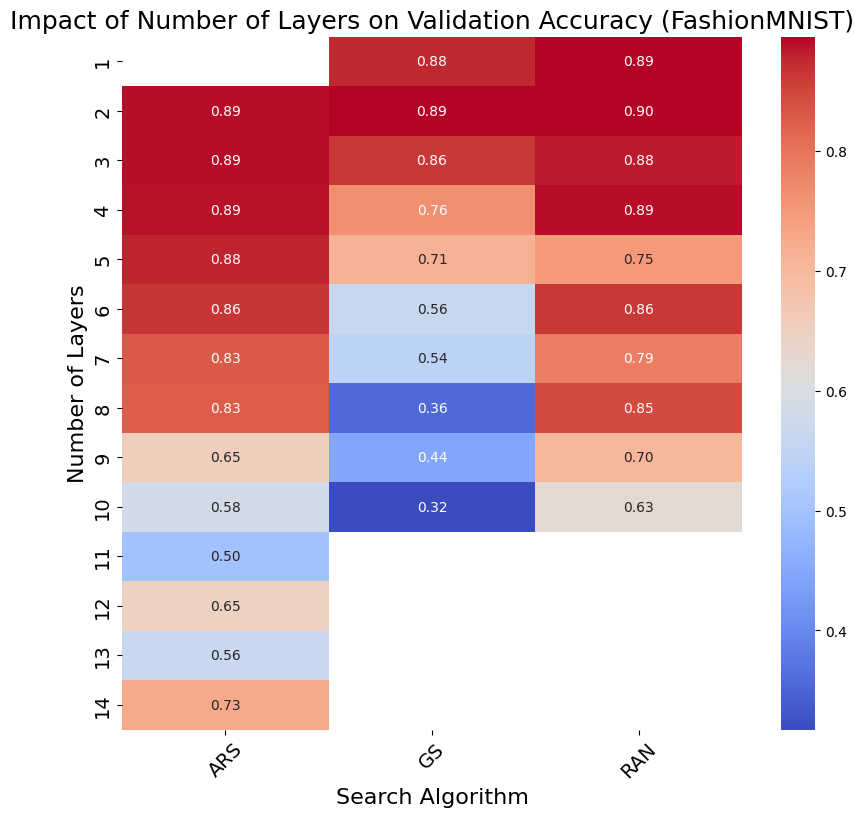

In [15]:

# Pivoting the dataframe for heatmap
heatmap_data = up_tobest_model.pivot_table(values="val_accuracy", index="layers_num", columns="algo", aggfunc=np.mean)

plt.figure(figsize=(10, 9))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Impact of Number of Layers on Validation Accuracy (FashionMNIST)", fontsize=18)
plt.xlabel("Search Algorithm", fontsize=16)
plt.ylabel("Number of Layers", fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("images/layersHeatmap_fashionMNIST.pdf", format='pdf', bbox_inches='tight')
plt.savefig("images/layersHeatmap_fashionMNIST.png", format='png', bbox_inches='tight')

plt.show()

In [16]:
up_tobest_model.columns

Index(['runNo', 'iteration_num', 'layers_num', 'neurons_num', 'val_accuracy',
       'training_time', 'time_to_reach_model', 'algo'],
      dtype='object')

In [17]:
len(up_tobest_model)

170

In [18]:
# We get the time up to the best model obtained
upto_best_models = up_tobest_model.groupby("algo").agg({
    "val_accuracy": ["mean", "max", "min"],
    "training_time": ["mean", "max", "min"],
    "time_to_reach_model": "mean"})
upto_best_models.columns = ["Avg Accuracy", "Max Accuracy", "Min Accuracy",
                      "Avg Training Time", "Max Training Time", "Min Training Time",
                      "Avg Time to Reach Model"]
upto_best_models

,Avg Accuracy,Max Accuracy,Min Accuracy,Avg Training Time,Max Training Time,Min Training Time,Avg Time to Reach Model
algo,,,,,,,
ARS,0.779973,0.8975,0.4150,56.738188,153.721875,26.328126,140.552488
GS,0.630762,0.8995,0.1925,89.889289,188.847188,25.194947,398.692607
RAN,0.803915,0.9045,0.0970,122.920234,268.403903,32.835186,470.905589


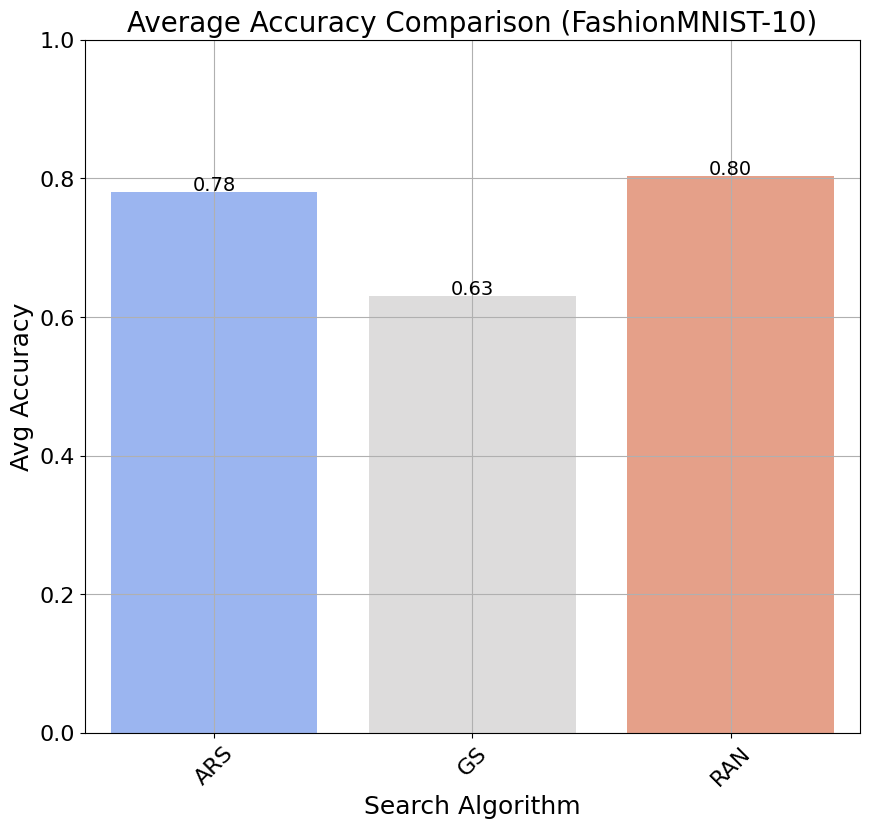

In [19]:
# Set Seaborn style
# Assuming 'upto_best_models' is already defined
plt.figure(figsize=(10, 9))
ax = sns.barplot(x="algo", y="Avg Accuracy", data=upto_best_models, palette="coolwarm")

# Add numerical values to the top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=14, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Set labels and title
plt.title("Average Accuracy Comparison (FashionMNIST-10)", fontsize=20)
plt.ylabel("Avg Accuracy", fontsize=18)
plt.xlabel("Search Algorithm", fontsize=18)
plt.ylim(0, 1)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.savefig("images/FashionMNISTaccuracy.pdf", format='pdf', bbox_inches='tight')
plt.savefig("images/FashionMNISTaccuracy.png", format='png', bbox_inches='tight')

plt.show()

In [20]:
upto_best_models

,Avg Accuracy,Max Accuracy,Min Accuracy,Avg Training Time,Max Training Time,Min Training Time,Avg Time to Reach Model
algo,,,,,,,
ARS,0.779973,0.8975,0.4150,56.738188,153.721875,26.328126,140.552488
GS,0.630762,0.8995,0.1925,89.889289,188.847188,25.194947,398.692607
RAN,0.803915,0.9045,0.0970,122.920234,268.403903,32.835186,470.905589


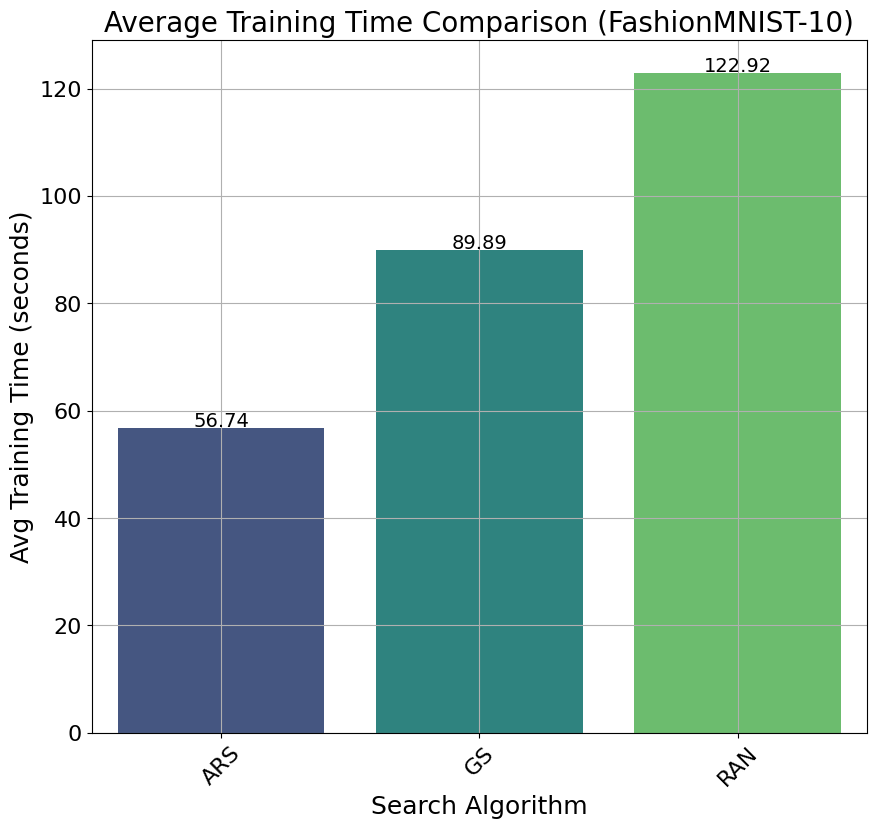

In [21]:
# Plot Training Time Comparison
plt.figure(figsize=(10, 9))
ax = sns.barplot(x="algo", y="Avg Training Time", data=upto_best_models, palette="viridis")

# Add numerical values to the top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=14, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Set labels and title
plt.title("Average Training Time Comparison (FashionMNIST-10)", fontsize=20)
plt.ylabel("Avg Training Time (seconds)", fontsize=18)
plt.xlabel("Search Algorithm", fontsize=18)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.savefig("images/FashionMNISTtime.pdf", format='pdf', bbox_inches='tight')
plt.savefig("images/FashionMNISTtime.png", format='png', bbox_inches='tight')

plt.show()

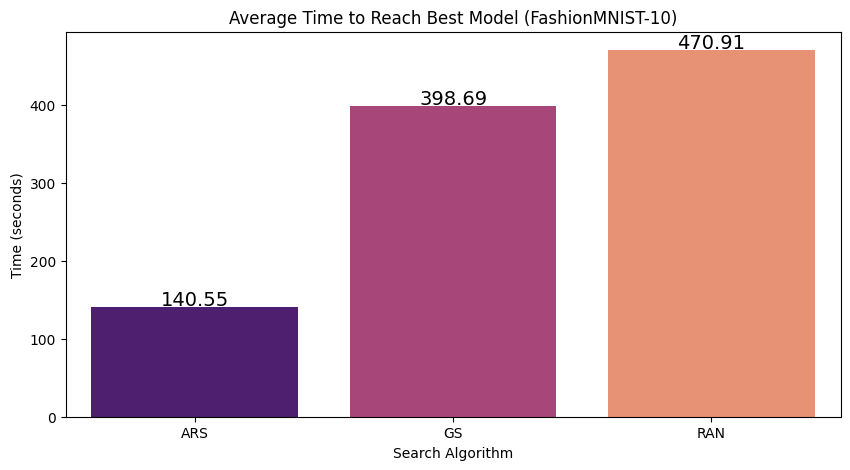

In [22]:
# Plot Time to Reach Best Model
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="algo", y="Avg Time to Reach Model", data=upto_best_models, palette="magma")

# Add numerical values to the top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=14, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Set labels and title
plt.title("Average Time to Reach Best Model (FashionMNIST-10)")
plt.ylabel("Time (seconds)")
plt.xlabel("Search Algorithm")
plt.show()

The average time taken to reach the best performing model varied significantly between the two datasets, with FashionMNIST-10 requiring substantially longer times (140.55 to 470.91 seconds) compared to CIFAR10 (108.38 to 137.92 seconds), indicating a more complex search space for FashionMNIST-10. Notably, ARS demonstrated the most consistent efficiency across both datasets, though it was relatively faster on CIFAR10, while GS consistently exhibited the slowest performance, highlighting its inefficiency. RAN, on the other hand, displayed the most variability, being the slowest on FashionMNIST-10 but the fastest on CIFAR10, suggesting its effectiveness is highly dependent on the dataset's specific characteristics, ultimately underscoring the interplay between dataset complexity and algorithm performance in automated machine learning.